In [1]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
from LinReg import PolyReg
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\CV-fitting'

In [2]:
def save_CV_fig(experiment, fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig(r"C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\CV_"+
                    analyte + electrode + solvent +
                    str(experiment.params.loc[experiment.params['parameter']=='scan_rate', 'value'].item()) + 'Vs-1_'+
                    notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

In [3]:
# Import Data
exp100 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.1Vs-1_P-07-02")
exp80 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.08Vs-1_P-07-04")
exp60 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.06Vs-1_P-07-05")
exp40 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.04Vs-1_P-07-06")


exp_series = [exp100, exp80, exp60, exp40]

{'ipa': 3.225299087690694e-05, 'Epa': 0.507194397797424, 'ipc': -2.465647400447535e-05, 'Epc': 0.42503322765483237}
{'ipa': 2.8305513377934203e-05, 'Epa': 0.5094313021676499, 'ipc': -2.0708996838998044e-05, 'Epc': 0.4236516086802093}
{'ipa': 2.633177463766793e-05, 'Epa': 0.5121945377788844, 'ipc': -1.7419432515243222e-05, 'Epc': 0.4282570009002074}
{'ipa': 2.17263842676539e-05, 'Epa': 0.5064706901784713, 'ipc': -1.3142998868323236e-05, 'Epc': 0.4286517477610897}


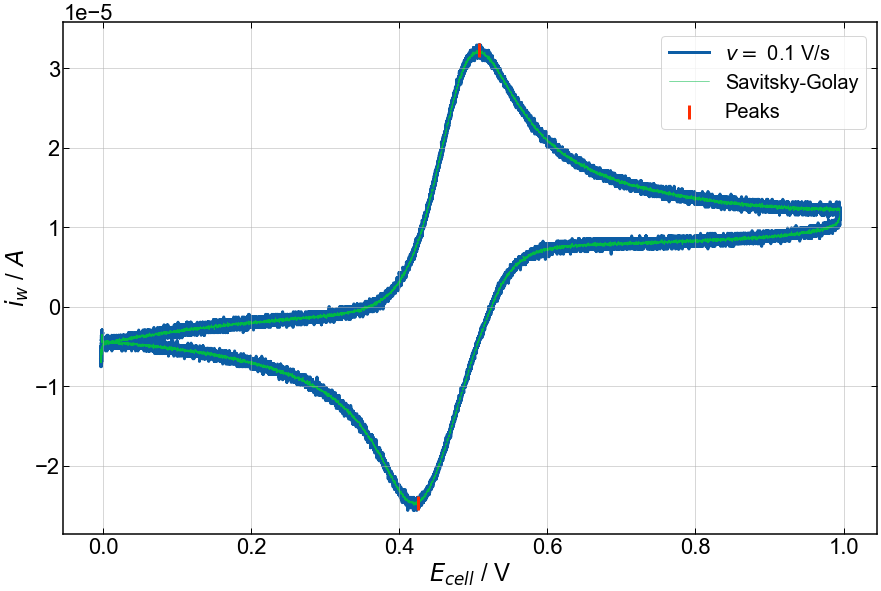

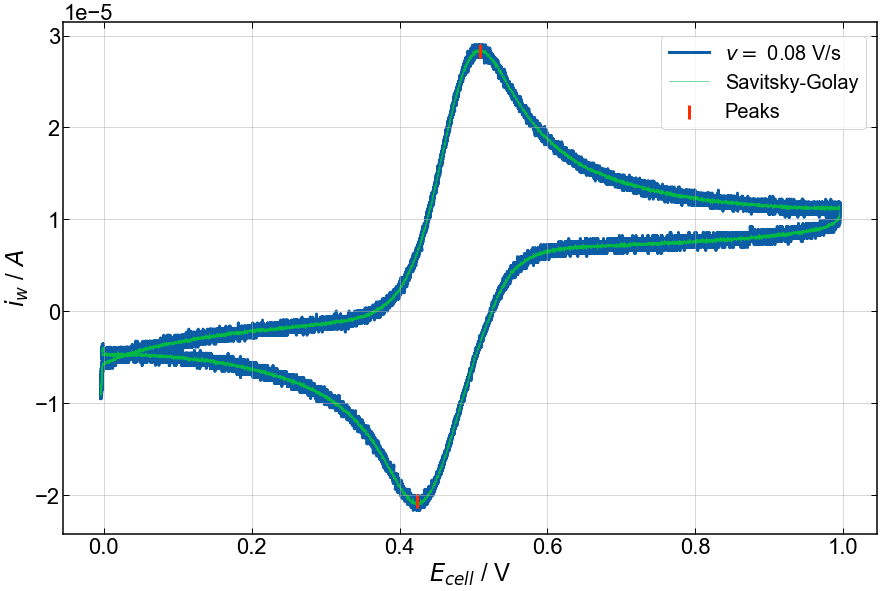

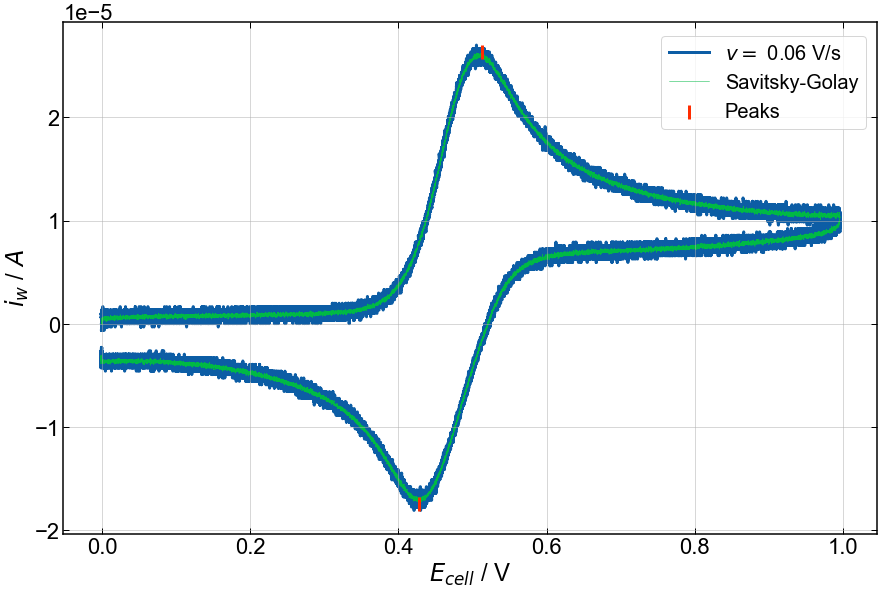

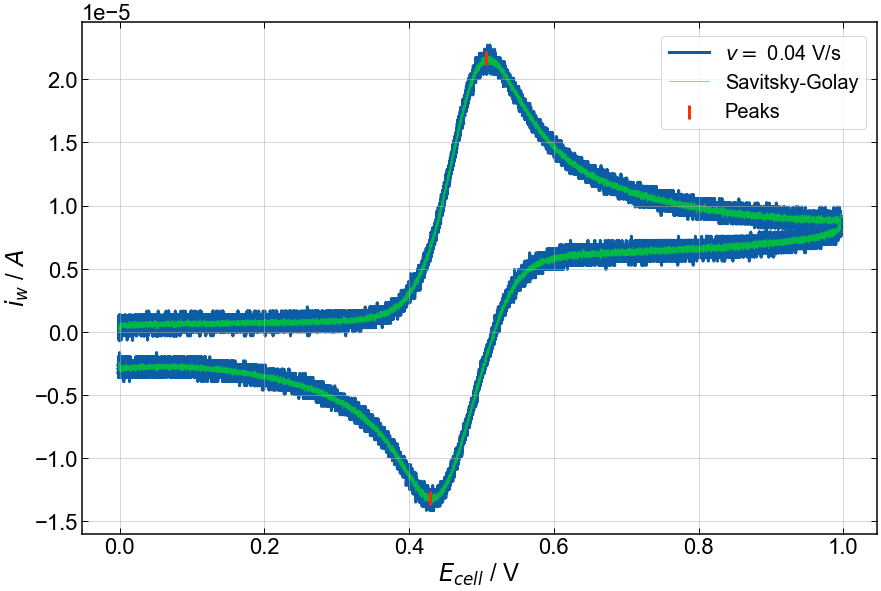

In [4]:
i = 0 # for setting savenames
picked_peaks = []
for exp in exp_series:
    # Apply iR correction for Ru determined by EIS fitting to the Randles circuit
    Ru = 4.00e+02 # Ohms
    exp.data['Ecell'] = exp.data['Ecell'] - Ru * exp.data['iw'] # 100% Compensation!

    # Smooth data using the Savitski Golay method
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 25, 2)

    # Maxima
    find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
    ipa, Epa = exp.data['iw'][find_ipa[0]].to_numpy(), exp.data['Ecell'][find_ipa[0]].to_numpy()

    # Invert signal to find minima - Signals are negative but indices are correct!
    find_ipc = find_peaks(-exp.data['savgol_iw'], height=0, width=3600) # Remember to un-invert anytime if calling ipc values from find_ipc, but not indicies.
    ipc, Epc = exp.data['iw'][find_ipc[0]].to_numpy(), exp.data['Ecell'][find_ipc[0]].to_numpy()

    peaks = {'ipa': ipa[0], 'Epa': Epa[0], 'ipc': ipc[0], 'Epc': Epc[0]}
    picked_peaks.append(pd.DataFrame(data=peaks, index=[0]))
    print(peaks)


    # Now some plotting
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.plot(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C2', label='Savitsky-Golay', lw=.5, zorder=.5)
    ax.scatter([*Epa, *Epc], [*ipa, *ipc], color='C1', label='Peaks', marker='|', s=200, zorder=1)
    fig.tight_layout()

    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))

    analyte = 'Fc_'
    electrode = 'GC_'
    solvent = 'MeCN'
    notebook = ['_P-07-02', '_P-07-04', '_P-07-05', '_P-07-06']

    # plt.show()
    # save_CV_fig(exp, fig, analyte, electrode, solvent, notebook[i])

    i += 1

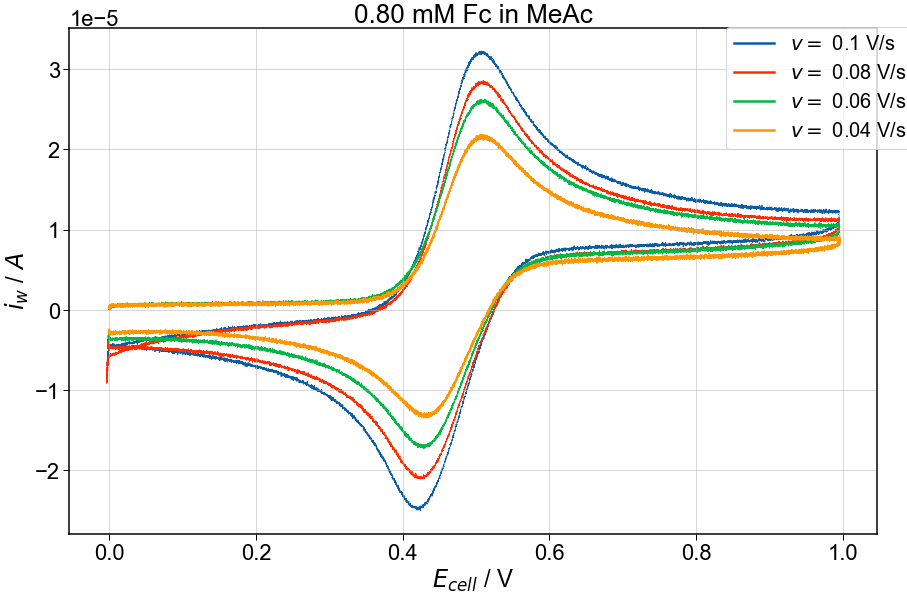

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

for exp in exp_series:
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'],
            label='$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s',
            lw=.5, zorder=.5)

fig.tight_layout()

ax.set_xlabel('$E_{cell}$ / V')
ax.set_ylabel('$i_{w}$ / $A$')
ax.set_title('0.80 mM Fc in MeAc')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
leg = fig.legend(loc=(0.80, 0.75))

for line in leg.get_lines():
    line.set_linewidth(2.5)

D = 3.7864975749979183e-06 cm2/s


coef_deg1       8.673775e-05
std_err_deg1    8.124965e-06
coef_deg0       4.515191e-06
std_err_deg0    2.149664e-06
r_squared       9.827535e-01
s_y             7.039168e-07
dtype: float64

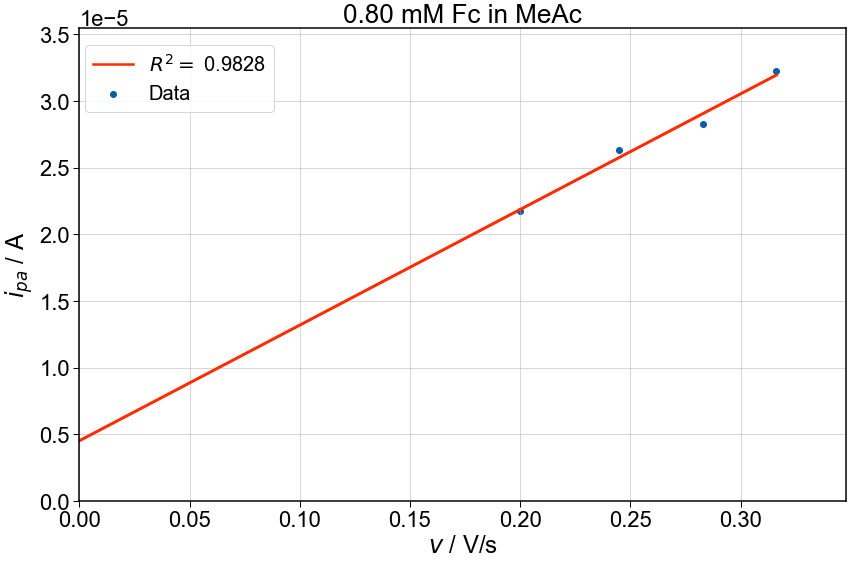

In [6]:
# Hey, actually you should fix b=0, which is not an existing functionality in PolyReg.

x, y = [], []
for i in range(len(exp_series)):
    x.append(np.sqrt(exp_series[i].params.loc[exp_series[i].params['parameter']=='scan_rate', 'value'].item()))
    y.append(picked_peaks[i]['ipa'].item())

x, y = np.array(x), np.array(y)

x2 = np.linspace(0, np.max(x), 1000)

fit = PolyReg(x, y, 1)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, label='Data', c='C0')
ax.plot(x2, fit.eval(x2), label='$R^2 =$ '+ '{:.4f}'.format(fit.r_squared), c='C1')

ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{pa}$ / A')
ax.set_title('0.80 mM Fc in MeAc')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set_xlim(0, np.max(x)*1.1)
ax.set_ylim(0, np.max(y)*1.1)

fig.tight_layout()

leg = fig.legend(loc=(0.10, 0.80))
for line in leg.get_lines():
    line.set_linewidth(2.5)


# Solving the Randles-Sevcik equation, and just using the intercept anyway for no reason
A = np.pi * (.5/2)**2 # cm2
CR = 0.8 / (10**6) # mol/cm3
D = ((fit.coef[0] - fit.coef[1]) / ((2.69*10**5) * A * CR))**2 # cm2/s
print('D = '+str(D)+' cm2/s')

fit.report()

D = 6.008293203447553e-06 cm2/s
[[3.78216189e-12]]
[-4.99755032e-07 -9.89433143e-07  9.61606748e-07  1.01172893e-06]
3.177015998610403e-12
5.7460757996869315e-11
0.007505845559575015
6.5104016758455e-07
0.9447098139780283
[1.94477811e-06]


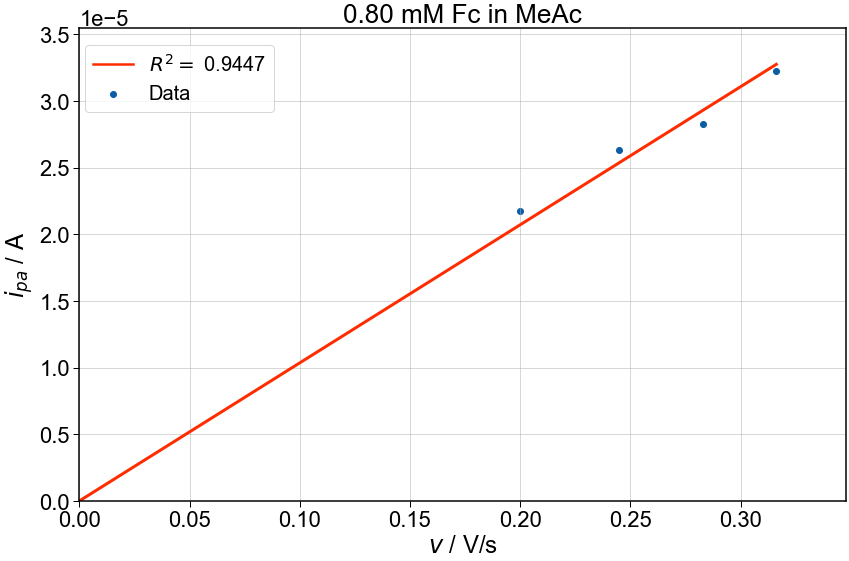

In [7]:
guess_m = 1.0e-04
fit, cov = curve_fit(lambda x, m : x*m, x, y, guess_m)

# Get the fitting parameter report manually, because scipy couldn't be bothered to.
residuals = y - fit[0]*x
ss_res = np.sum(residuals**2)
ss_yy = np.sum((y - np.mean(y)) ** 2)
ss_xx = np.sum((x - np.mean(x)) ** 2)
ss_xy = np.sum((x - np.mean(x))*(y - np.mean(y)))
r_squared = 1 - (ss_res / ss_yy)
std_err = np.sqrt(np.diag(cov))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, label='Data', c='C0')
ax.plot(x2, fit[0]*x2, label='$R^2 =$ '+ '{:.4f}'.format(r_squared), c='C1')

ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{pa}$ / A')
ax.set_title('0.80 mM Fc in MeAc')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set_xlim(0, np.max(x)*1.1)
ax.set_ylim(0, np.max(y)*1.1)

fig.tight_layout()

leg = fig.legend(loc=(0.10, 0.80))
for line in leg.get_lines():
    line.set_linewidth(2.5)

# Solving the Randles-Sevcik equation
A = np.pi * (.5/2)**2 # cm2
CR = 0.8 / (10**6) # mol/cm3
D = (fit[0]  / ((2.69*10**5) * A * CR))**2 # cm2/s
print('D = '+str(D)+' cm2/s')

print(cov, residuals, ss_res, ss_yy, ss_xx, ss_xy, r_squared, std_err, sep='\n')
# fig.savefig(r'..\data\figs\Fc_MeAc_Randles-Sevcik.png')